## Импорты и установка модулей и библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from calendar import day_name

#для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)},style="whitegrid")
import matplotlib.dates as mdates


# для декомпозиции и для моделей
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Считывание датафрейма и подготовка данных

In [2]:
df = pd.read_csv("/content/HistoricalData_1742404356306.csv", parse_dates=['Date'])

In [3]:
df['Open']=df['Open'].str.replace('$','')
df['Close/Last']=df['Close/Last'].str.replace('$','')
df['High']=df['High'].str.replace('$','')
df['Low']=df['Low'].str.replace('$','')

In [4]:
df['Open']=df['Open'].astype(float)
df['Close/Last']=df['Close/Last'].astype(float)
df['High']=df['High'].astype(float)
df['Low']=df['Low'].astype(float)

In [5]:
df_copy = df.set_index('Date').asfreq('B')
df_copy['Close/Last'] = df_copy['Close/Last'].interpolate(method='time')
df_copy['Volume'] = df_copy['Volume'].interpolate(method='time')
df_copy['Open'] = df_copy['Open'].interpolate(method='time')
df_copy['High'] = df_copy['High'].interpolate(method='time')
df_copy['Low'] = df_copy['Low'].interpolate(method='time')
df_copy['year'] = df_copy.index.year #добавим год для джойна
df_copy = df_copy.reset_index()

In [16]:
df_copy_2 = df_copy[['Date', 'Close/Last']]

In [17]:
df_copy_2 = df_copy_2.set_index('Date')

In [18]:
split_date='2025-01-01'

In [19]:
test = df_copy_2.loc[split_date:]
train = df_copy_2.loc[:split_date]

## Простые адаптивные модели

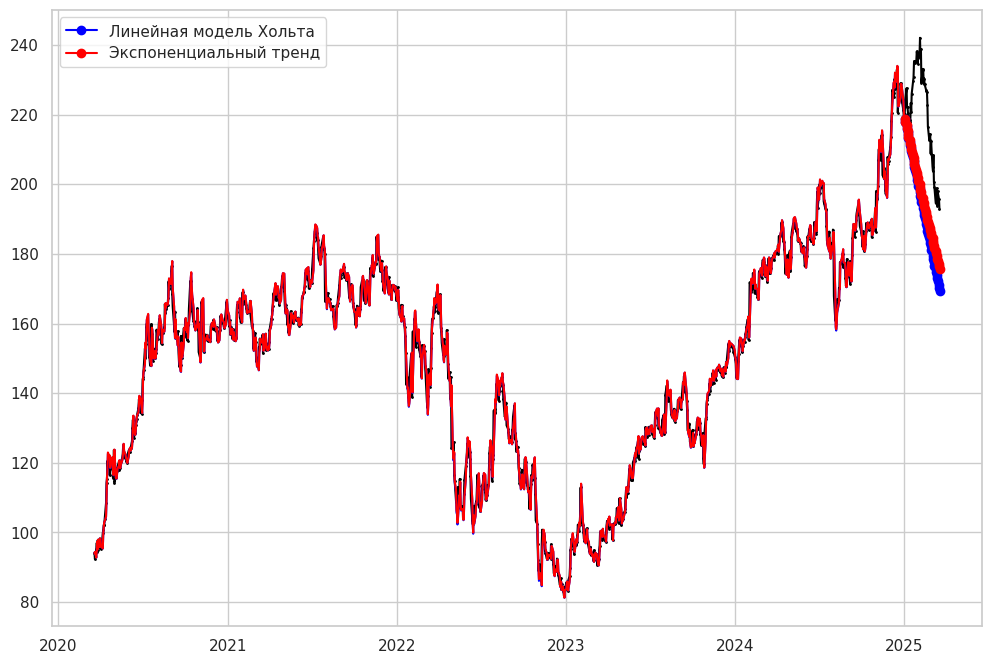

In [20]:
fit1 = Holt(train['Close/Last'], initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(55).rename("Линейная модель Хольта")

fit2 = Holt(train['Close/Last'], exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(55).rename("Экспоненциальный тренд")

plt.figure(figsize=(12, 8))
plt.plot(df_copy_2['Close/Last'], marker="o", color="black", markersize=1)
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.legend([line1, line2], [fcast1.name, fcast2.name])
plt.show()

## Мультипликативные вариации модели Хольта-Винтерса

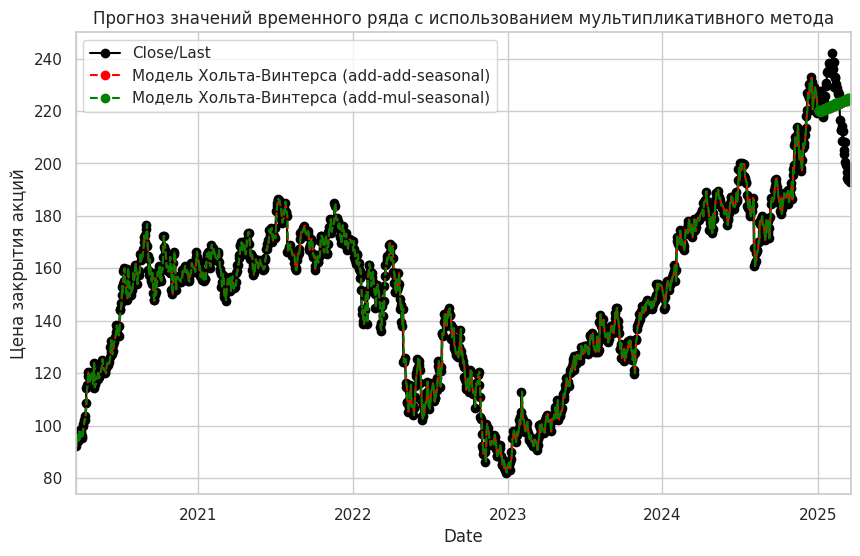

In [21]:
fit3 = ExponentialSmoothing(train,seasonal_periods=7,trend="add",seasonal="add",
                            use_boxcox=True,initialization_method="estimated",
                            ).fit()
fit4 = ExponentialSmoothing(train,seasonal_periods=7,trend="add",seasonal="mul",
                            use_boxcox=True,initialization_method="estimated",
                            ).fit()

ax = df_copy_2.plot(figsize=(10, 6),marker="o",color="black",
    title="Прогноз значений временного ряда с использованием мультипликативного метода",)
ax.set_ylabel("Цена закрытия акций")
ax.set_xlabel("Year")
fit3.fittedvalues.plot(ax=ax, style="--", color="red")
fit4.fittedvalues.plot(ax=ax, style="--", color="green")

fit3.forecast(55).rename("Модель Хольта-Винтерса (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit4.forecast(55).rename("Модель Хольта-Винтерса (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()

## Модель локального глобального тренда

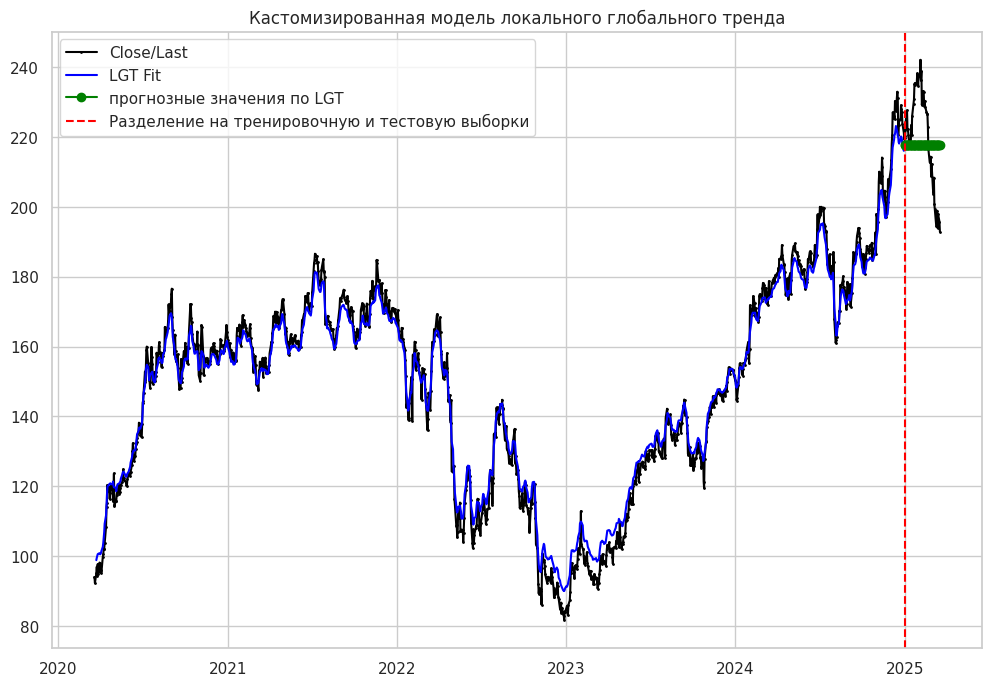

In [22]:
# 1. Глобальный тренд (полиномиальная регрессия)
X_global = np.arange(len(train)).reshape(-1, 1)
y_global = train['Close/Last'].values
global_model = LinearRegression()
global_model.fit(X_global, y_global)
global_trend = global_model.predict(X_global)

# 2. Локальный тренд (скользящее среднее)
window_size = 5
local_trend = train['Close/Last'].rolling(window=window_size, center=True).mean()

# Комбинированная модель LGT
train['LGT'] = 0.1 * global_trend + 0.9 * local_trend

future_periods = 86
last_train_idx = len(train) - 1

X_future = np.arange(last_train_idx + 1, last_train_idx + 1 + future_periods).reshape(-1, 1)
global_forecast = global_model.predict(X_future)

last_local = local_trend.iloc[-window_size:].mean()
local_forecast = np.full(future_periods, last_local)

# Комбинированный прогноз
combined_forecast = 0.1 * global_forecast + 0.9 * local_forecast

freq = 'B'
forecast_dates = pd.date_range(start=test.index[0], periods=future_periods, freq=freq)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'LGT_Forecast': combined_forecast})
forecast_df = forecast_df.set_index('Date')

plt.figure(figsize=(12, 8))
plt.plot(df_copy_2.index, df_copy_2['Close/Last'], marker='o', color='black', markersize=1, label='Close/Last')
plt.plot(train.index, train['LGT'], color='blue', label='LGT Fit')
plt.plot(forecast_df.index, forecast_df['LGT_Forecast'], marker='o', color='green', label='прогнозные значения по LGT')
plt.axvline(x=pd.to_datetime(split_date), color='red', linestyle='--', label='Разделение на тренировочную и тестовую выборки')
plt.legend()
plt.title('Кастомизированная модель локального глобального тренда')
plt.grid(True)
plt.show()

## Расчет величины ошибок прогнозных значений

In [23]:
models = [
    ("Линейная модель Хольта", fcast1),
    ("Экспоненциальный тренд", fcast2),
    ("Модель Хольта-Винтерса (add-add-seasonal)", fit3.forecast(55)),
    ("Модель Хольта-Винтерса (add-mul-seasonal)", fit4.forecast(55)),
    ("Кастомизированная модель LGT", forecast_df['LGT_Forecast'])
]

metrics_data = []

for name, forecast in models:
    actual = test['Close/Last'][:len(forecast)]

    mae = mean_absolute_error(actual, forecast)
    mape = mean_absolute_percentage_error(actual, forecast) * 100
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    metrics_data.append({
        'Model': name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Model,MAE,MAPE,RMSE
0,Линейная модель Хольта,26.659839,12.008914,29.204268
1,Экспоненциальный тренд,24.175645,10.833595,26.759479
2,Модель Хольта-Винтерса (add-add-seasonal),11.968469,5.597434,14.918598
3,Модель Хольта-Винтерса (add-mul-seasonal),11.999393,5.614245,14.971138
4,Кастомизированная модель LGT,12.216259,5.580006,14.174066
